In [29]:
# this is a notebook to evaluate easily
# firstly we want to encode the data from pbmc3k
# import a shitload of packages 
# Autoencoder notebook but not for training just for using to encode and decode
import sys
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
from typing import List, Optional, Callable
import torch.nn as nn
import torch.nn.functional as F
from scvi.distributions import NegativeBinomial
import torch.nn.functional as F
import scanpy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append("/dtu/blackhole/0e/214382/Isoflow")
from autoencoder_utils import NB_Autoencoder 
from autoencoder_utils import CountsDataset


In [30]:
# imoport the autoencoder model and the train data
model_path=  "/dtu/blackhole/0e/214382/datasets/pbmc3k/pbmc3k_train_nb_autoencoder.pt"
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters 
num_features = 8573  # number of genes/features
latent_dim = 50

# Instantiate the model
model = NB_Autoencoder(num_features=num_features, latent_dim=latent_dim)
model.to(device)

# Load trained weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # set to evaluation mode
# import the latent space of this model
adata = ad.read_h5ad("/dtu/blackhole/0e/214382/datasets/pbmc3k/pbmc3k_train.h5ad")
X = adata.layers["X_counts"]
if hasattr(X, "toarray"):
    X = X.toarray()
X = torch.tensor(X, dtype=torch.float32)
print(X.shape)
#Latent space saved to /dtu/blackhole/0e/214382/datasets/pbmc3k/pbmc3k_train_with_latent.h5ad

torch.Size([2110, 8573])


In [31]:
# encode the data from pbmc3k
# and generate latent
num_genes = adata.n_vars
# -------------------------------
latent_dim = 50
hidden_dims = [512, 256]
batch_size = 512
epochs = 1000
learning_rate = 1e-3
epochs_list=[]
loss_list=[]
dataset = CountsDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/dtu/blackhole/0e/214382/datasets/pbmc3k/pbmc3k_train_nb_autoencoder.pt"
model = NB_Autoencoder(num_features=num_genes,
                       latent_dim=latent_dim,
                       hidden_dims=hidden_dims)
model.load_state_dict(torch.load(model_path, map_location=device))

model = model.to(device)

# --- Save encoded training cells to train flow model---
model.eval()
all_z = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}
        outputs = model.forward(batch)

        z = outputs["z"].cpu().numpy()
        all_z.append(z)

latent = np.concatenate(all_z, axis=0)

# Save to AnnData
adata.obsm["X_latent"] = latent
print(latent)
latent_tensor = torch.tensor(latent, dtype=torch.float32, device = device)



/zhome/6a/4/214382/Isoflow/autoencoder_utils.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 50.59it/s]

[[-2.4736297   4.7983055  -0.750344   ... -0.64571625 -0.38973305
  -0.6169763 ]
 [ 0.19786601  1.7384617   2.812365   ... -0.30235922 -1.6681975
   0.6786578 ]
 [ 1.7975683   1.1099886  -1.5111676  ... -0.36095676 -0.052548
   0.77744037]
 ...
 [ 3.3853383  -1.8531286  -1.834433   ... -0.8582413  -3.0935585
   0.52355593]
 [-1.7437724   0.06532679  1.4296098  ... -1.8220763   1.2810097
   0.8079806 ]
 [-0.52416044 -1.0797474   1.8602942  ... -1.548523   -0.2628697
   0.44389075]]


In [32]:
from Train_flow import LearnedVectorFieldODE, NeuralVectorField
import torch
from Train_flow import LearnedVectorFieldODE
from Train_flow import GaussianConditionalProbabilityPath
from Train_flow import EulerSimulator
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1️⃣ Create vf_model and load weights
vf_model = NeuralVectorField(latent_dim=latent_dim)   # use the same latent_dim as in training
vf_model.load_state_dict(torch.load("vf_model_weights.pt", map_location=device))
vf_model = vf_model.to(device)
vf_model.eval()



# train vf_model from scratch


vf_model.load_state_dict(torch.load("vf_model_weights.pt", map_location=device))
vf_model.eval()
# 2️⃣ Wrap the loaded vf_model in LearnedVectorFieldODE
learned_ode = LearnedVectorFieldODE(vf_model)
learned_ode = learned_ode.to(device)
learned_ode.eval()

# ✅ Now you can call
# output = learned_ode.drift_coefficient(x, t, z)


LearnedVectorFieldODE(
  (vf_model): NeuralVectorField(
    (x_proj): Linear(in_features=50, out_features=256, bias=True)
    (z_proj): Linear(in_features=50, out_features=256, bias=True)
    (time_embedder): TimeEmbedder(
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): SiLU()
        (4): Linear(in_features=128, out_features=64, bias=True)
      )
    )
    (resblocks): ModuleList(
      (0-4): 5 x ResNetBlock(
        (block): Sequential(
          (0): Linear(in_features=576, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=576, bias=True)
          (3): LayerNorm((576,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (output_layer): Sequential(
      (0): Linear(in_features=576, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=5

In [34]:
stats = torch.load("normalization_stats.pt", map_location=device)
u_mean = stats['u_mean']
u_std = stats['u_std']


In [33]:

class EulerSimulator():
    def __init__(self, ode, z: torch.Tensor, u_mean, u_std):
        self.ode = ode
        self.z = z
        self.u_mean = u_mean
        self.u_std = u_std

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: float):
        # Expand z to match batch size
        if self.z.shape[0] == 1:
            z_exp = self.z.expand(xt.shape[0], -1)
        else:
            z_exp = self.z

        # Get normalized drift from model
        dx_norm = self.ode.drift_coefficient(xt, t, z_exp)

        # Un-normalize to match the real vector field scale
        dx = dx_norm * self.u_std + self.u_mean

        # Euler update
        return xt + dx * h

In [35]:
class ODEFunc(nn.Module):
    def __init__(self, vf_model):
        super().__init__()
        self.vf_model = vf_model

    def forward(self, t, x):
        # t is scalar tensor
        # x is (batch_size, latent_dim)
        dxdt = self.vf_model(x, t)  # your vector field model
        return dxdt


In [41]:
#with euler simulator
#this is the workflow for generating latent space with flow model
# Number of samples and latent dimension
n_samples = 500
latent_dim = latent.shape[1]

# Starting points (noise)
x = torch.randn(n_samples, latent_dim, device=device)

# Conditioning variable z
# Single vector, broadcast to all samples
z = torch.zeros(1, latent_dim, device=device)  # or z = emp_dist.sample(1)
#indices = torch.randint(0, latent_tensor.shape[0], (n_samples,))
#z = latent_tensor[indices].to(device)

# Wrap the trained neural network as an ODE
learned_ode = LearnedVectorFieldODE(vf_model)

# Create Euler simulator with the conditioning variable
simulator = EulerSimulator(learned_ode, z, u_mean, u_std)

# Simulation parameters
t0, t1 = 0.0, 1.0
n_steps = 150
dt = (t1 - t0) / n_steps

# Store trajectory
trajectory = [x.clone()]
t = torch.full((n_samples, 1), t0, device=device)

# Euler integration
for _ in range(n_steps):
    x = simulator.step(x, t, dt)
    trajectory.append(x.clone())
    t = t + dt

# Final generated samples
generated_cells = trajectory[-1]
print(generated_cells.shape)  # (1000, latent_dim)
torch.save(generated_cells, "generated_latent.pt")
print(generated_cells, latent)

torch.Size([500, 50])
tensor([[ 0.4880,  0.5053,  0.3984,  ..., -0.1674, -0.0874,  0.4245],
        [-0.3362, -0.3188, -0.1038,  ...,  0.6399, -0.0491,  0.2083],
        [-0.4143, -0.2808, -0.0053,  ...,  0.3333, -0.7858, -0.3777],
        ...,
        [-0.0207,  0.0554, -0.3433,  ...,  0.1388,  0.3520,  0.0177],
        [ 0.0165, -0.6030, -0.0599,  ...,  0.0100, -0.1961, -0.1151],
        [-0.0275,  0.3508, -0.4136,  ..., -0.0899, -0.0090, -0.5315]],
       device='cuda:0', grad_fn=<CloneBackward0>) [[-2.4736297   4.7983055  -0.750344   ... -0.64571625 -0.38973305
  -0.6169763 ]
 [ 0.19786601  1.7384617   2.812365   ... -0.30235922 -1.6681975
   0.6786578 ]
 [ 1.7975683   1.1099886  -1.5111676  ... -0.36095676 -0.052548
   0.77744037]
 ...
 [ 3.3853383  -1.8531286  -1.834433   ... -0.8582413  -3.0935585
   0.52355593]
 [-1.7437724   0.06532679  1.4296098  ... -1.8220763   1.2810097
   0.8079806 ]
 [-0.52416044 -1.0797474   1.8602942  ... -1.548523   -0.2628697
   0.44389075]]


In [37]:
class NeuralVectorField(nn.Module):
    def __init__(self, latent_dim, hidden_dim=256, n_resblocks=5, time_embed_dim=64):
        super().__init__()
        self.x_proj = nn.Linear(latent_dim, hidden_dim)
        self.z_proj = nn.Linear(latent_dim, hidden_dim)
        self.time_embedder = TimeEmbedder(time_embed_dim)

        self.resblocks = nn.ModuleList([
            ResNetBlock(hidden_dim*2 + time_embed_dim, hidden_dim*2) for _ in range(n_resblocks)
        ])
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim*2 + time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x, z, t):
    # x, z: (batch, latent_dim)
        # t: (batch, 1)
        xh = self.x_proj(x)
        zh = self.z_proj(z)
    
        th = self.time_embedder(t)  # should return (batch, time_embed_dim)
        if th.dim() == 1:
            th = th.unsqueeze(0)
    
        h = torch.cat([xh, zh, th], dim=-1)
        for block in self.resblocks:
            h = block(h)
        return self.output_layer(h)


In [58]:
# with another ODE interpreter
#this is the workflow for generating latent space with flow model
# Number of samples and latent dimension
n_samples = 100
latent_dim = latent.shape[1]
n_steps = 300
class ODEFunc(nn.Module):
    def __init__(self, vf_model, z):
        super().__init__()
        self.vf_model = vf_model
        self.z = z  # fixed conditioning

    def forward(self, t, x):
        batch_size = x.shape[0]

        # Expand conditioning z to match batch
        if self.z.shape[0] == 1:
            z = self.z.expand(batch_size, -1)
        else:
            z = self.z

        # Expand t to batch dimension for concatenation
        if t.dim() == 0:
            t_batch = t.expand(batch_size, 1)  # (batch, 1)
        else:
            t_batch = t.view(batch_size, -1)   # (batch, 1) if 1D

        return self.vf_model(x, z, t_batch)


from torchdiffeq import odeint_adjoint as odeint

n_samples = 500
latent_dim = latent.shape[1]

x0 = torch.randn(n_samples, latent_dim, device=device)
z_cond = torch.zeros(1, latent_dim, device=device)

ode_func = ODEFunc(vf_model, z_cond)

# only endpoints
t_span = torch.tensor([0.0, 1.0], device=device)

# integrate
trajectory = odeint(ode_func, x0, t_span, method='dopri5')

# final states only
generated_cells = trajectory[-1]
print(generated_cells)
torch.save(generated_cells, "generated_latent.pt")


tensor([[-0.0977,  0.0171,  0.0962,  ...,  0.0529,  0.1786,  0.1879],
        [ 0.3453,  0.0606,  0.1953,  ..., -1.0226,  0.7335,  0.1023],
        [ 0.2832,  0.0808, -0.2677,  ...,  1.2172, -1.0316, -0.1518],
        ...,
        [ 1.4652, -0.6459, -1.3020,  ..., -0.6140,  0.9000, -0.2255],
        [-0.0320,  0.0381, -0.3686,  ..., -0.4050,  0.3425,  0.4972],
        [-0.5671,  0.0619,  0.6828,  ...,  1.3255,  0.2018,  0.9708]],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [17]:
# If latent is a tensor, detach first
if isinstance(latent, torch.Tensor):
    original_latent = latent.detach().cpu().numpy()
else:
    original_latent = latent  # already numpy

if isinstance(generated_cells, torch.Tensor):
    generated_latent = generated_cells.detach().cpu().numpy()
else:
    generated_latent = generated_cells  # already numpy

# Now you can compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(original_latent, generated_latent)
print("Mean cosine similarity:", sim_matrix.mean())


Mean cosine similarity: -0.0021167933


In [34]:
from sklearn.metrics import pairwise_distances

dist_matrix = pairwise_distances(original_latent, generated_latent, metric='euclidean')
mean_dist = dist_matrix.mean()
min_dist = dist_matrix.min()
max_dist = dist_matrix.max()

print("Mean Euclidean distance:", mean_dist)
print("Min distance:", min_dist)
print("Max distance:", max_dist)


Mean Euclidean distance: 11.929382
Min distance: 7.266691
Max distance: 15.753808


/zhome/6a/4/214382/venv_2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


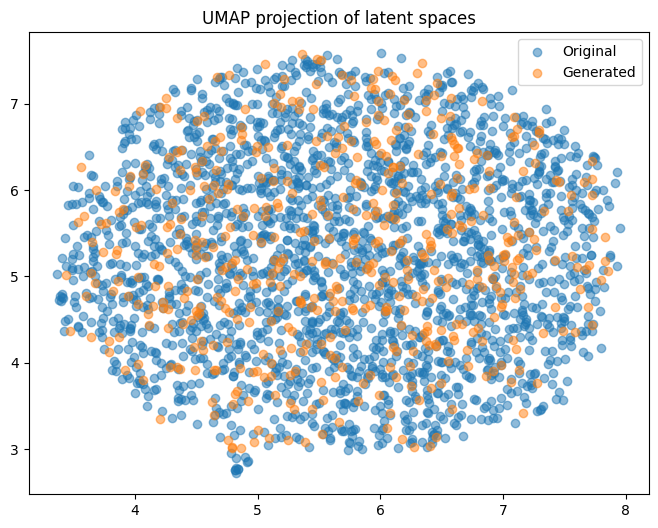

In [18]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Combine for projection
combined = np.vstack([original_latent, generated_latent])
labels = np.array([0]*original_latent.shape[0] + [1]*generated_latent.shape[0])

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(combined)

plt.figure(figsize=(8,6))
plt.scatter(embedding[labels==0,0], embedding[labels==0,1], alpha=0.5, label="Original")
plt.scatter(embedding[labels==1,0], embedding[labels==1,1], alpha=0.5, label="Generated")
plt.legend()
plt.title("UMAP projection of latent spaces")
plt.show()


In [63]:
# Move latent and generated cells to device
latent_tensor = torch.tensor(latent, dtype=torch.float32, device=device)
generated_tensor = torch.tensor(generated_cells, dtype=torch.float32, device=device)
X_merged = []
labels = []
# Compute per-dimension standard deviation
std_orig = latent_tensor.std(dim=0)
std_gen = generated_tensor.std(dim=0)

# Rescale generated latent to match original std
generated_rescaled = (generated_tensor - generated_tensor.mean(dim=0)) / std_gen * std_orig + latent_tensor.mean(dim=0)

with torch.no_grad():
    # Decode original latent cells
    outputs_latent = model.decode(latent_tensor, 1800)
    mu_latent = outputs_latent["mu"]
    theta_latent = torch.exp(outputs_latent["theta"])

    # Decode flow-generated latent cells
    #outputs_gen = model.decode(generated_tensor, 1800)
    outputs_gen = model.decode(generated_rescaled, 1800)
    mu_gen = outputs_gen["mu"]
    theta_gen = torch.exp(outputs_gen["theta"])
    
    #X_hat = NegativeBinomial(mu=mu_hat, theta=torch.exp(model.theta)).sample() # We <3 Mikkel

    # Sample from NB distribution
    nb_latent = NegativeBinomial(mu=mu_latent, theta=torch.exp(model.theta)).sample() 

    nb_generated = NegativeBinomial(mu=mu_gen, theta=torch.exp(model.theta)).sample() 
    X_merged.append(nb_latent.cpu().numpy())
    X_merged.append(nb_generated.cpu().numpy())
    labels.extend(["Real" for _ in range(len(nb_latent))])
    labels.extend(["Generated" for _ in range(len(nb_generated))])
print("Original latent sampled shape:", nb_latent.shape)
print("Flow-generated sampled shape:", nb_generated.shape)
torch.save(generated_cells, "generated_latent.pt")

Original latent sampled shape: torch.Size([2110, 8573])
Flow-generated sampled shape: torch.Size([500, 8573])


/tmp/ipykernel_120806/1210648913.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  generated_tensor = torch.tensor(generated_cells, dtype=torch.float32, device=device)


In [64]:
adata_gen = ad.AnnData(X=nb_generated.cpu().numpy())

# Assign gene names from test dataset
adata_gen.var_names = adata.var_names.copy()

# All generated cells are B cells
#adata_gen.obs["cell_type"] = "B cells"
adata_gen.obs["dataset"] = "generated"

#sc.pp.filter_genes(adata, min_cells=20)

# Save the generated AnnData
adata_gen.write("generated_anndata.h5ad")



In [18]:
# Difference between generated points and conditioning z
diff = torch.norm(generated_cells - z, dim=1)
print(diff.mean(), diff.max())


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [65]:
X_merged = np.concatenate(X_merged)
adata = sc.AnnData(X=X_merged, 
                   obs={"dataset_type": labels})
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

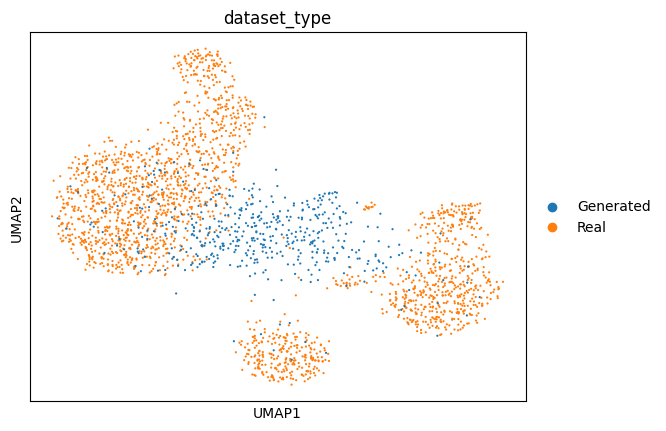

In [66]:
sc.pl.umap(adata, color="dataset_type", s=10, save="autoencoder_test_umap_w_reg.png")